# Data Analysis
Author: Leon Yin<br>
Date: 2020-2-03<br>

This notebook analyses the results of the element categorization and area estimations from the last notebook.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [139]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [3]:
import os
import sys
import json
import time
import glob
import tempfile
import warnings
import inspect
from collections import Counter
from multiprocessing import Pool
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy.stats import t
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from bs4 import BeautifulSoup
from tqdm import tqdm
from IPython.display import display

sys.path.append("..")
from utils.config import (
    google_domains,
    cat2color
)

In [4]:
# input
fn_metadata = '../data/intermediary/element_metadata_15k.jsonl.gz'

# output
output_dir = '../data/output'
tables_dir = os.path.join(output_dir, 'tables/')
figure_dir = os.path.join(output_dir, 'figures/')
appendix_dir = os.path.join(output_dir, 'appendix/')

for d in [tables_dir, figure_dir, appendix_dir]:
    os.makedirs(d, exist_ok=True)

In [5]:
df = pd.read_json(fn_metadata, lines=True, 
                  compression='gzip')

In [66]:
df.fn_input.nunique()

15268

In [78]:
print(json.dumps(df.sample(1).iloc[-1].to_dict(), 
                 indent=2))

{
  "text": "Videos",
  "link": null,
  "domain": "google.com",
  "xpath": "/html/body/div[10]/div/div[6]/div/div[3]/div/div/div/sticky-header/div[1]/div/g-tabs/div/div[1]/a[4]",
  "element_class": "KYeOtb|ih2ainT7gdI__unselected|M51USb",
  "category": "link-knowledge_panel_tab",
  "tag": "a",
  "attrs": {
    "jsname": "AznF2e",
    "class": [
      "KYeOtb",
      "ih2ainT7gdI__unselected",
      "M51USb"
    ],
    "aria-selected": "false",
    "data-index": "3",
    "style": "height:48px;color:#802929;border-color:#D24040;padding:0 12px",
    "tabindex": "-1",
    "role": "tab",
    "jsaction": "h5M12e"
  },
  "dimensions": {
    "height": 48.0,
    "width": 71.1333312988
  },
  "location": {
    "x": 287,
    "y": 234
  },
  "area": 3414.3999023438,
  "area_page": 3414.3999023438,
  "fn_input": "../data/input/google_search/iPhone-X/2019/12/23/Yuji-Horii/html/webpage_raw.html",
  "label": "link",
  "category_standard": "google-knowledge-panel-links"
}


In [6]:
# first glance
df.groupby('label') \
  .area.sum() \
  .sort_values(ascending=False) / df.area.sum()

label
link       0.395101
answer     0.230873
organic    0.184833
amp        0.124067
ads        0.065125
Name: area, dtype: float64

In [7]:
# full page
df.groupby('label') \
  .area_page.sum() \
  .sort_values(ascending=False)/ df.area_page.sum()

label
organic    0.443422
link       0.277567
amp        0.136076
answer     0.133365
ads        0.009570
Name: area_page, dtype: float64

## Breakdown of area and frequency for each category

In [8]:
# get area per standardized category
cat_area_ = (df.groupby('category_standard')
               .area_page.sum()
               .divide(df.area_page.sum()))

cat_area =(df.groupby('category_standard')
             .area.sum()
             .divide(df.area.sum()))

In [9]:
(df.groupby('category_standard')
             .area.sum()
             .divide(df.area.sum()))

category_standard
ads                             0.065125
amp-card                        0.118022
amp-search_result               0.003497
amp-visual_stories              0.002548
google-answer                   0.202433
google-expandable-answer        0.028440
google-images                   0.146953
google-knowledge-panel-links    0.080761
google-maps                     0.015258
google-misc                     0.102599
google-search                   0.029488
google-video                    0.020043
organic                         0.069843
organic-search_result           0.114990
Name: area, dtype: float64

In [10]:
n_pages = df[df.area != 0].fn_input.nunique()

In [11]:
# number of elements on first glance
cat_count = Counter()
for fn, _df in df[df.area != 0].groupby('fn_input'):
    cat_count.update(_df.category_standard.unique())
df_wc = pd.DataFrame(cat_count.most_common(50),
                     columns=['category_standard', 'count'])
df_wc['freq'] = df_wc['count'] / n_pages 

# number of elements on full page
cat_count_ = Counter()
for fn, _df in df[df.area_page != 0].groupby('fn_input'):
    cat_count_.update(_df.category_standard.unique())
df_wc_ = pd.DataFrame(cat_count_.most_common(50),
                     columns=['category_standard', 'count_page'])
df_wc_['freq_page'] = df_wc_['count_page'] / n_pages 

In [12]:
cat_amp = df[df.label == 'amp'].category_standard.unique()
cat_sd = df[df.label == 'link'].category_standard.unique()
cat_rt = df[df.label == 'answer'].category_standard.unique()
cat_ad = df[df.label == 'ads'].category_standard.unique()
cat_og = df[df.label == 'organic'].category_standard.unique()

In [13]:
cat_og

array(['organic-search_result', 'organic'], dtype=object)

In [14]:
def format_number(x):
    """Makes it nice for printing"""
    x = x * 100
    x = round(x, 2)
    return f"{x}%"

In [15]:
def breakdown(categories : list(), 
              col='category_standard'):
    """Shows the area coverage and page frequency for each category  """
    full_page =df_wc_[df_wc_[col].isin(categories)] \
            .join(cat_area_.to_frame(),
                  on=col,
                  how='left')

    output = (df_wc[df_wc[col].isin(categories)]
        .join(cat_area.to_frame(),
              on=col,
              how='left')
        .sort_values(by=['area'], 
                     ascending=False)
        .reset_index(drop=True)
        .merge(full_page)
    )
    
    output = output[[c for c in output.columns if 'count' not in c]]
        
    fg_area = output['area'].sum()
    fp_area = output['area_page'].sum()
    
    output = output.append(
        {'category_standard' : 'Total', 
         'freq' : np.nan, 
         'area' : fg_area, 
         'freq_page' : np.nan, 
         'area_page' : fp_area},
        ignore_index=True
    )
    return output.set_index(col)


## Breakdown of area and frequency for each category

In [16]:
columns = [
   ('Above the fold', 'area'),
   ('Above the fold' , 'area'),
   ('Full page', 'freq'),
   ('Full page' , 'area'),
]

In [17]:
total_area = df['area'].sum()
total_area_fp = df['area_page'].sum()
n_pages = df.fn_input.nunique()

In [18]:
label2publabel = {
    'link' : 'Google Product',
    'answer' : 'Google Answer',
    'organic' : 'Organic',
    'amp' : 'AMP',
    'ads' : 'Ads'
}

In [19]:
labels = [
    'organic',
    'amp',
    'link',
    'answer',
    'ads'
]

In [20]:
df_cat_agg = pd.DataFrame()
for categories in [cat_ad, cat_amp, cat_rt, cat_sd, cat_og]:
    output = breakdown(categories)
    df_cat_agg = df_cat_agg.append(output)
    
    output.columns = pd.MultiIndex.from_tuples([
       ('Above the fold', 'freq'),
       ('Above the fold' , 'area'),
       ('Full page', 'freq'),
       ('Full page' , 'area'),
    ])
    for c, dtype in output.dtypes.items():
        if pd.api.types.is_numeric_dtype(output[c]):
            output[c] = output[c].apply(format_number)
    
    display(output)

Above the fold        Full page       
                            freq   area      freq   area
category_standard                                       
ads                        7.87%  6.51%     9.51%  0.96%
Total                       nan%  6.51%      nan%  0.96%

Above the fold         Full page        
                             freq    area      freq    area
category_standard                                          
amp-card                    17.5%   11.8%    61.01%   4.84%
amp-search_result           1.04%   0.35%    65.57%   8.67%
amp-visual_stories          1.85%   0.25%     5.52%    0.1%
Total                        nan%  12.41%      nan%  13.61%

Above the fold         Full page        
                                   freq    area      freq    area
category_standard                                                
google-answer                    59.39%  20.24%     93.9%   5.91%
google-expandable-answer         16.15%   2.84%    89.75%   7.43%
Total                              nan%  23.09%      nan%  13.34%

Above the fold         Full page        
                                       freq    area      freq    area
category_standard                                                    
google-images                        59.08%   14.7%    85.81%   2.69%
google-misc                          84.21%  10.26%    99.17%   3.46%
google-knowledge-panel-links         66.96%   8.08%    73.96%   1.12%
google-search                        20.46%   2.95%    99.99%  15.77%
google-video                         11.15%    2.0%    63.06%   4.35%
google-maps                            5.6%   1.53%     9.46%   0.37%
Total                                  nan%  39.51%      nan%  27.76%

Above the fold         Full page        
                                freq    area      freq    area
category_standard                                             
organic-search_result         22.66%   11.5%    99.96%  37.81%
organic                       63.66%   6.98%    94.98%   6.53%
Total                           nan%  18.48%      nan%  44.34%

In [29]:
data = {}
for label in labels:
    _df = df[df.label == label]
    area = (_df['area'].sum() / total_area)
    area_page = (_df['area_page'].sum() / total_area_fp)
    freq = _df[_df['area'] != 0].fn_input.nunique() / n_pages
    freq_page = _df[_df['area_page'] != 0].fn_input.nunique() /n_pages
    data[label2publabel.get(label,label)] = {
        ('Above the fold', 'frequency') : freq,
        ('Above the fold', 'area') : area,
        ('First page', 'Frequency') : freq_page,
        ('First page', 'area') : area_page,
    }
    
cat_breakdown = pd.DataFrame(data).T
cat_breakdown.columns = pd.MultiIndex.from_tuples([
    ('Above the fold', 'frequency'),
    ('Above the fold', 'area'),
    ('First page', 'Frequency'),
    ('First page', 'area'),
])
print((cat_breakdown * 100).round(1).astype(str) + '%')

               Above the fold        First page       
                    frequency   area  Frequency   area
Organic                 74.3%  18.5%     100.0%  44.3%
AMP                     20.2%  12.4%      80.7%  13.6%
Google Product          92.4%  39.5%     100.0%  27.8%
Google Answer           66.3%  23.1%      99.4%  13.3%
Ads                      7.9%   6.5%       9.5%   1.0%


In [40]:
39.5 + 23.1

62.6

In [41]:
27.8 + 13.3

41.1

In [22]:
fn_cats = '../data/output/tables/T1_area_freq_by_category.csv'
cat_breakdown.to_csv(fn_cats)

## Changes in Category between full page of first glance

In [23]:
legend_elements = [Patch(facecolor=cat2color['link'], 
                         label='Google link'),
                   Patch(facecolor=cat2color['answer'], 
                         label='Google answer'),
                   Patch(facecolor=cat2color['amp'], 
                         label='AMP'),
                   Patch(facecolor=cat2color['ads'], 
                         label='Ads'),
                   Patch(facecolor=cat2color['organic'], 
                         label='Organic')]

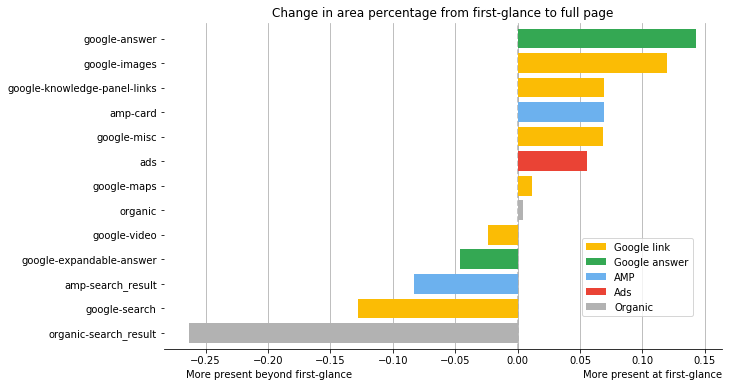

In [24]:
df_cat_agg = df_cat_agg[df_cat_agg.index != 'Total']
df_cat_agg['area_delta'] = df_cat_agg['area'] - df_cat_agg['area_page']
df_plot = df_cat_agg['area_delta'].sort_values(ascending=True)
df_plot = df_plot[abs(df_plot) > .002]
colors = []
for c in df_plot.index:
    if c in cat_ad:
        colors.append(cat2color['ads'])
    elif c in cat_amp:
        colors.append(cat2color['amp'])
    elif c in cat_og:
        colors.append(cat2color['organic'])
    elif c in cat_rt:
        colors.append(cat2color['answer'])
    elif c in cat_sd:
        colors.append(cat2color['link'])
    else:
        colors.append('black')
        
ax = df_plot.plot(kind='barh', 
                  figsize=[10,6],
                  width=.8,
                  color=colors,
                  title='Change in area percentage from first-glance to full page')

plt.axvline(x=0, color='k', linestyle='--', zorder=-1, alpha = .3)

ax.set_axisbelow(True)
plt.gca().xaxis.grid(True)
# plt.gca().yaxis.grid(True)
ax.set_ylabel("")

ax.legend(handles=legend_elements, 
          loc=(.75,.1))

plt.annotate('More present beyond first-glance', 
             (0.04, 0), (0, -21), 
             xycoords='axes fraction', 
             textcoords='offset points', 
             va='top')
plt.annotate('More present at first-glance', 
             (.75, 0), (.75, -21), 
             xycoords='axes fraction', 
             textcoords='offset points', 
             va='top')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom');

## Histogram of Google-occupied pixels

\begin{equation}
X_{goog} = \frac{g}{g + o}
\end{equation}

\begin{equation}
X_{goog} = \frac{g + ad}{o + g + ad}
\end{equation}

\begin{equation}
X_{goog} = \frac{g + amp}{o + g + amp}
\end{equation}

\begin{equation}
X_{goog} = \frac{g + amp + ad}{o + g + amp + ad}
\end{equation}

\begin{equation}
X_{goog} = \frac{g}{o + g + amp + ad}
\end{equation}

\begin{equation}
X_{o} = \frac{o}{o + g + amp + ad}
\end{equation}


Where <br>
&nbsp;&nbsp;&nbsp;&nbsp; $X_{goog}$: is the percentage of real estate that occupy Google elements.<br>
&nbsp;&nbsp;&nbsp;&nbsp; $g$: is the total sum of variable real estate pixels occupied by Google links and answers.<br>
&nbsp;&nbsp;&nbsp;&nbsp; $o$: is the total sum of variable real estate pixels occupied by Organic links.<br>
&nbsp;&nbsp;&nbsp;&nbsp; $ad$: is the total sum of variable real estate pixels occupied by ads.<br>
&nbsp;&nbsp;&nbsp;&nbsp; $amp$: is the total sum of variable real estate pixels occupied by AMP.<br>

In [25]:
pixels = {
    'area' : [],
    'area_page' : []
}
for search, df_ in tqdm(df.groupby('fn_input')):
    for col in ['area', 'area_page']:
        ad = df_[df_.label == 'ads'][col].sum()
        o = df_[df_.label == 'organic'][col].sum()
        g = df_[(df_.label == 'link') | 
                (df_.label == 'answer')][col].sum()
        amp = df_[df_.label == 'amp'][col].sum()

        e1 = g / (g + o)
        
        e2 = (g + ad) / (g + o + ad )
        e3 = (g + amp) / (g + o + amp)
        e4 = (g + amp + ad) / (g + o + amp + ad)
        e5 = g / (g + ad + o + amp)
        
        e6 =  o / (g + ad + o + amp)
        

        row = {
            'search_term' : search,
            'ad' : ad,
            'o' : o,
            'g' : g,
            'amp' : amp,
            'e1' : e1,
            'e2' : e2,
            'e3' : e3,
            'e4' : e4,
            'e5' : e5,
            'e6' : e6
        }

        pixels[col].append(row)
    
df_pixels = pd.DataFrame(pixels['area'])
df_pixels_fp = pd.DataFrame(pixels['area_page'])

100%|██████████| 15268/15268 [01:15<00:00, 202.68it/s]


In [30]:
df_pixels.e1.fillna(0, inplace=True)

In [31]:
def hist(series, color='black', 
         title=None, 
         fn_out=None,
         left_right_annotations = (None, None)):
    ax = series.plot(kind='hist', 
                           figsize=(10,6),
                           bins=10, 
                           rwidth=.95,
                           color=color,
                           alpha=.9,
                           title=title)

    ax.tick_params(axis="both", which="both", bottom="off", 
                   top="off", labelbottom="on", left="off", 
                   right="off", labelleft="on")

    plt.annotate(left_right_annotations[0], 
                 (0.04, 0), (0, -21), 
                 xycoords='axes fraction', 
                 textcoords='offset points', 
                 va='top')
    plt.annotate(left_right_annotations[-1], 
                 (.75, 0), (.75, -21), 
                 xycoords='axes fraction', 
                 textcoords='offset points', 
                 va='top')

    ax.set_ylabel("Count of search pages")

    ax.set_axisbelow(True)
    plt.gca().yaxis.grid(True)

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    if fn_out:
         plt.savefig(fn_out)
    
    return ax

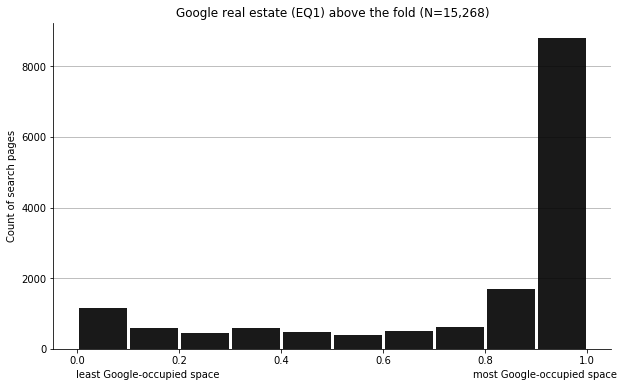

In [32]:
hist(df_pixels.e1,
     left_right_annotations = ('least Google-occupied space',
                             'most Google-occupied space'),
     title = f'Google real estate (EQ1) above the fold (N={len(df_pixels):,})',
     fn_out='../data/output/figures/eq1_abv.png');

In [55]:
# What percentage of pages have 90% or more of the page occupied by Google?
len(df_pixels[df_pixels.e1 >= .9]) / len(df_pixels) * 100

57.61068902279277

In [54]:
# what percentage of pages have less than 10% google
len(df_pixels[df_pixels.e1 == 0]) / len(df_pixels) * 100

4.276919046371496

In [112]:
df_pixels.e1.mean(), df_pixels.e1.median()

(0.772679777588408, 0.9851683929156346)

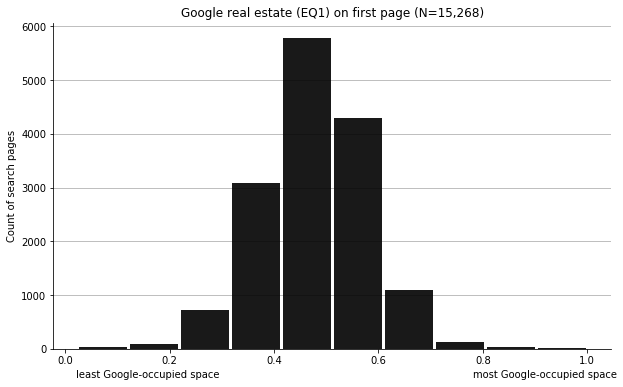

In [33]:
hist(df_pixels_fp.e1,
     title = f'Google real estate (EQ1) on first page (N={len(df_pixels_fp):,})',
     left_right_annotations = ('least Google-occupied space',
                               'most Google-occupied space'),
     fn_out='../data/output/figures/eq1_page.png');

In [58]:
# What percentage of pages have 50% or more of the page occupied by Google?
len(df_pixels_fp[df_pixels_fp.e1 >= .5]) / len(df_pixels) * 100

41.18417605449306

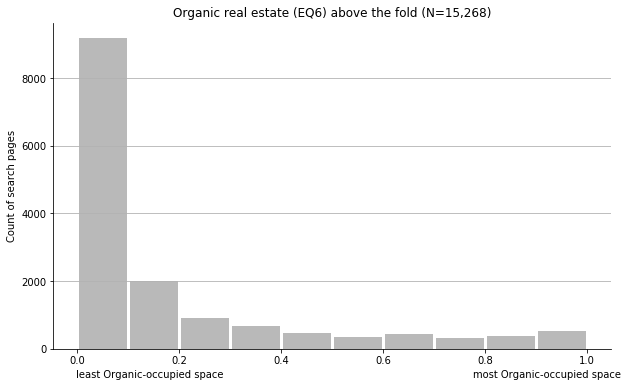

In [34]:
hist(df_pixels.e6,
     color=cat2color['organic'],
     title=f'Organic real estate (EQ6) above the fold (N={len(df_pixels):,})',
     left_right_annotations=('least Organic-occupied space',
                             'most Organic-occupied space'),
     fn_out='../data/output/figures/eq6_above.png')

In [53]:
# What percentage of pages have 95% or more of the page occupied by self-dealing?
len(df_pixels[df_pixels.e6 <= .1]) / len(df_pixels) * 100

60.1061042703694

## Computing confidence interval

In [35]:
def SEM(data : pd.DataFrame, 
        confidence : float = 0.95 , 
        scale : int = 100,
        return_tuple = False) -> str:
    """Calculates standard error of the mean."""
    n = len(data)
    m = data.mean()
    std_err = data.sem()
    h = std_err * t.ppf((1 + confidence) / 2, n - 1)
    s = f"{scale * m:.1f} ± {h * scale :.1f}"
    if return_tuple:
        s = (m, h)
    return s

In [137]:
index2human = {
    'e1' : 'R1: g / (o + g)',
    'e2' : 'R2: (g + ad) / (o + g + ad)',
    'e3' : 'R3: (g + amp) / (o + g + amp)',
    'e4' : 'R4: (g + amp + ad) / (o + g + amp + ad)',
    'e5' : 'R5: g / (o + g + ads + amp)',
    'e6' : 'R6: o / (o + g+ ads + amp)',
}

In [138]:
results = {}
for e in [f'e{i}' for i in range(1, 7)]:
    x_goog = SEM(df_pixels[e])
    x_goog_fp = SEM(df_pixels_fp[e])
    results[index2human.get(e)] = {
        'above the fold' : x_goog + '%',
        'first page' : x_goog_fp+ '%'
    }
ratios = pd.DataFrame(results).T
ratios.to_csv('../data/output/tables/ratios.csv')
ratios

,above the fold,first page
R1: g / (o + g),77.3 ± 0.5%,47.6 ± 0.2%
R2: (g + ad) / (o + g + ad),80.3 ± 0.5%,48.2 ± 0.2%
R3: (g + amp) / (o + g + amp),81.1 ± 0.5%,54.1 ± 0.2%
R4: (g + amp + ad) / (o + g + amp + ad),82.8 ± 0.4%,54.5 ± 0.2%
R5: g / (o + g + ads + amp),65.2 ± 0.6%,40.4 ± 0.1%
R6: o / (o + g+ ads + amp),17.2 ± 0.4%,45.5 ± 0.2%


No matter what you might consider to be "Google"...
Above the fold is covered with Google properties between 64.6% and 83.2%.
For the first page it is between 40.3% and 54.7%.

# Distance

In [81]:
df.loc[:, 'y_dist'] = df.location.apply(lambda x: x['y'])

In [82]:
df.loc[df['category'] == 'link-youtube', 
       "category_standard"] = 'youtube'

In [83]:
standard_categories = [
    "organic-search_result",
    "organic",
    "ads",
    "amp-card",
    "amp-visual_stories",
    "google-images",
    "youtube",
    "google-maps",
    'google-answer',
    "google-search",
    "google-expandable-answer",
]

In [85]:
df.category_standard.value_counts()

google-search                   287491
google-answer                   126432
organic                         116455
google-misc                     111118
organic-search_result           106591
google-images                   104599
google-expandable-answer        102004
youtube                          80144
google-knowledge-panel-links     58940
amp-card                         56022
amp-search_result                24518
ads                               4566
google-maps                       1942
google-video                      1090
amp-visual_stories                 885
Name: category_standard, dtype: int64

In [86]:
dist = {k : [] for k in standard_categories}
for site, _df in df[df.area_page != 0].groupby('fn_input'):
    for cat in standard_categories:
        __df = _df[_df.category_standard == cat]
        if not __df.empty:
            y_min = __df.y_dist.min()
            dist[cat].append(y_min)

In [87]:
for k, v in dist.items():
    print(k)
    print(len([_ for _ in v if _]))

organic-search_result
15261
organic
14500
ads
1452
amp-card
9314
amp-visual_stories
842
google-images
13101
youtube
9624
google-maps
1444
google-answer
14336
google-search
15266
google-expandable-answer
13702


In [119]:
dato.describe()['25%']

1004.25

In [122]:
data = []
for cat, v in dist.items():
    dato = pd.DataFrame({'dist_y' : v}).dist_y
    mean = dato.mean()
    median = dato.median()
    err = dato.sem()
    std = dato.std()
    data.append({
        'category' : cat,
        'dist' : mean,
        'dist_median' : median,
        'min' : dato.describe()['min'],
        '25' : dato.describe()['25%'],
        '50' : dato.describe()['50%'],
        '75' : dato.describe()['75%'],
        'max' : dato.describe()['max'],
        'std' : std,
        'sem_error' : err,
        'n' : len(v)
    })
df_dist = pd.DataFrame(data)
del data

In [131]:
df_dist = df_dist[df_dist['category'] != 'organic]'].sort_values(by='dist')#.to_csv('are_these_outliers.csv', index=False)

In [135]:
data

,category,dist,dist_median,min,25,50,75,max,std,sem_error,n
0,ads,593.873278,166.0,166.0,166.00,166.0,185.00,8190.0,1159.411776,30.426668,1452
1,google-images,676.225250,355.0,148.0,287.00,355.0,944.00,5995.0,631.584432,5.517968,13101
2,organic,823.689172,616.0,166.0,518.00,616.0,1002.25,5120.0,546.820352,4.541096,14500
3,google-answer,846.192732,565.5,166.0,426.00,565.5,1129.00,5391.0,635.682588,5.309166,14336
4,google-maps,973.165512,649.5,166.0,230.00,649.5,1391.25,4997.0,936.144433,24.635380,1444
5,amp-visual_stories,1189.165083,1092.0,399.0,689.00,1092.0,1624.50,4085.0,527.568005,18.181194,842
6,organic-search_result,1400.407575,1343.0,166.0,873.00,1343.0,1939.00,4944.0,765.712552,6.198324,15261
7,google-search,1654.120726,1416.0,159.0,917.00,1416.0,2201.00,6560.0,1085.801620,8.787956,15266
8,amp-card,1723.634636,1669.5,166.0,545.25,1669.5,2575.75,6616.0,1117.770257,11.582023,9314
9,youtube,2136.228699,2209.0,166.0,1137.75,2209.0,3017.25,5846.0,1113.115299,11.346511,9624


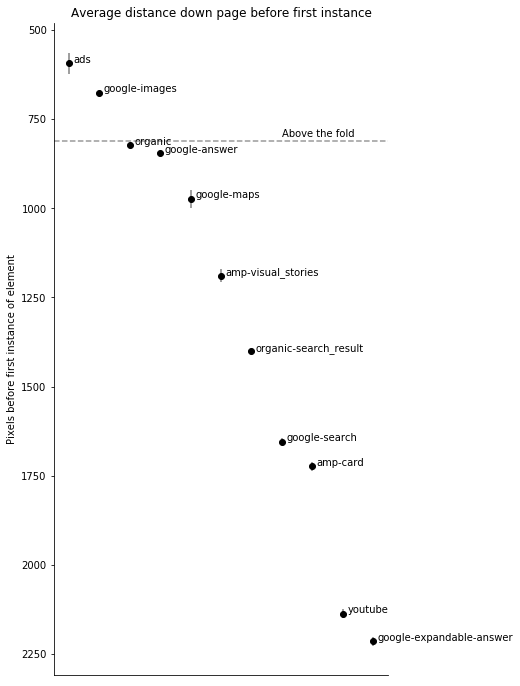

In [136]:
fig, ax = plt.subplots(figsize=(6, 12))
data = df_dist
col = 'dist'
plt.errorbar(data.category, col, yerr='sem_error', 
             ecolor='grey', color='black',
             data=data, fmt='o')
plt.gca().invert_yaxis()
plt.axhline(y=812, color='black', linestyle='--', alpha=.4)
plt.annotate('Above the fold', (7, 800))


plt.xticks(rotation=90)

for i, (_, row) in enumerate(data.iterrows()):
#     txt = f"{row['category']} (N={row['n']:,})"
    txt = row['category']
    y = row[col] - 2
    x = (1 * i) + .15
    if txt == 'google-expandable_answer':
        x = (1 * i) - 2
    plt.annotate(txt, (x, y))
    
ax.set_ylabel("Pixels before first instance of element")
plt.title('Average distance down page before first instance')
ax.set_axisbelow(True)
# plt.gca().yaxis.grid(True)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.xaxis.set_visible(False)
plt.savefig('../data/output/figures/distance.png')
del data;

## How many Blue Links are in a page?

In [57]:
blue_links = []
for search, _df in df[df.area_page != 0].groupby('fn_input'):
    n_blue = len(_df[_df['category_standard'] == 'organic-search_result'])

    blue_links.append({
        'fn_input' : search,
        'n_blue_links' : n_blue
        
    })
df_bl = pd.DataFrame(blue_links)

In [58]:
df_bl.n_blue_links.mean()

6.981333507990568

In [60]:
df_bl.n_blue_links.sem()

0.015463731748338518

In [64]:
df_bl.describe()

,n_blue_links
count,15268.000000
mean,6.981334
std,1.910757
min,0.000000
25%,6.000000
50%,7.000000
75%,8.000000
max,12.000000


In [63]:
df_bl[df_bl.n_blue_links == 0].fn_input.tolist()

['../data/input/google_search/iPhone-X/2019/11/07/ENGIE/html/webpage_raw.html',
 '../data/input/google_search/iPhone-X/2019/12/06/Naval-Air-Station-Pensacola/html/webpage_raw.html',
 '../data/input/google_search/iPhone-X/2019/12/09/Google-Sheets/html/webpage_raw.html',
 '../data/input/google_search/iPhone-X/2019/12/25/Guelph/html/webpage_raw.html',
 '../data/input/google_search/iPhone-X/2019/12/26/Game-of-Thrones/html/webpage_raw.html',
 '../data/input/google_search/iPhone-X/2020/01/01/Hiro-Mashima/html/webpage_raw.html',
 '../data/input/google_search/iPhone-X/2020/01/02/Nick-Gordon/html/webpage_raw.html']

# AMP
How many sites are using AMP compared to how many sites we have?

In [ ]:
from urlexpander import get_domain

n_domains_amp = (df[df.label == 'amp']
                    .link.apply(get_domain)
                    .nunique())

In [ ]:
n_domains_og = df[df.label == 'organic'].domain.nunique()

In [ ]:
n_domains_amp / (n_domains_amp + n_domains_og)

In [ ]:
(df[df.label == 'amp']
    .link.apply(get_domain)
    .value_counts()
    .head(10))

In [ ]:
(df[(df.label == 'amp') &
    (df.area != 0)]
    .link.astype(str).apply(get_domain)
    .value_counts()
    .head(10))

## Organic
How far do you have to go to get an organic link?

In [ ]:
blue_link_count = Counter()
for site, _df in tqdm(df[df.area_page != 0].groupby('fn_input')):
    blue_link_count.update([len(_df[_df.label == 'organic'])])

In [ ]:
blue_link_count.most_common()

In [ ]:
df[df.label == 'organic'].category.value_counts()

In [72]:
df.loc[:, 'y_dist'] = df.location.apply(lambda x: x['y'])

In [ ]:
dist = {}
for site, _df in tqdm(df[df.area_page != 0].groupby('fn_input')):
    y_min = _df[_df.category == 'organic-search_result'].y_dist.min()
    if y_min:
        dist[site] = y_min
        
df_dist = pd.DataFrame([{'page' : k, 'y_dist' : v} for k,v in dist.items()])
t_student_confidence_interval(df_dist.y_dist,
                              scale=1)

In [ ]:
df_dist = df_dist[~df_dist.y_dist.isnull()]

In [ ]:
ax = df_dist.groupby(pd.cut(df_dist.y_dist.clip(0, 3000), 40)).size().iloc[::-1].plot(
    kind='barh',
    figsize=(10, 10),
    color='black',
    alpha=.9,
    title='Pixels until first organic search result')


ax.set_axisbelow(True)
plt.gca().yaxis.grid(True)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom');

In [ ]:
result = df_dist.y_dist.value_counts().reset_index()
result.columns = ['y_dist', 'count']
# result['y_dist'] = result['y_dist'].clip(0, 1000)

What percentages of pages have first organic link past the first glance?

What percentages of pages have first organic link past the first glance

In [ ]:
df_dist[df_dist['y_dist'] > 812].page.nunique() / df.fn_input.nunique()

Average distance before first organic link

In [ ]:
t_student_confidence_interval(df_dist.y_dist,
                              scale=1)

In [ ]:
dist = {}
for site, _df in tqdm(df[df.area_page != 0].groupby('fn_input')):
    y_min = _df[_df.label == 'organic'].y_dist.min()
    if y_min:
        dist[site] = y_min
        
df_dist = pd.DataFrame([{'page' : k, 'y_dist' : v} for k,v in dist.items()])
t_student_confidence_interval(df_dist.y_dist,
                              scale=1)

In [ ]:
df_dist[df_dist['y_dist'] > 812].page.nunique() / df.fn_input.nunique()

In [ ]:
organic_down_under = df_dist[df_dist.y_dist > 2500].page

In [ ]:
sample = df[(df.fn_input.isin(organic_down_under))
          & (df.category == 'organic-search_result')]

In [ ]:
cols = [
    'link',
    'domain',
    'fn_input',
    'y_dist'
]

In [ ]:
sample = sample[cols].sort_values(by='y_dist').drop_duplicates(subset=['fn_input'])

In [ ]:
sample['search terms'] = sample.fn_input.apply(lambda x: x.split('/')[-3].replace('-', ' '))

In [ ]:
sample.to_csv('organic_down_under.csv', index=False)

In [ ]:
org = Counter()

In [ ]:
for page, _df in sample.groupby('fn_input'):
    _df.sort_values('y_dist', inplace=True)
    org.update([_df.iloc[0].domain])

In [ ]:
org.most_common(40)

In [ ]:
df[df['category'] == 'organic-search_result'].domain.value_counts().head(20)

In [ ]:
df[df['category'] == 'organic'].domain.value_counts().head(20)

In [ ]:
len(df[df['category'] == 'link-youtube'])

In [ ]:
df[df['category'] == 'link-youtube'].fn_input.nunique() / df.fn_input.nunique()

In [ ]:
len(df[df['category'] == 'link-youtube']) / df[df['category'] == 'link-youtube'].fn_input.nunique()

In [ ]:
other_videos = [
    'dailymotion.com',
    'vimeo.com',
    'joyofbaking.com'
]